In [1]:
include("./Open2sPIN/Open2PIN.jl")
using .Open2PIN

using Tullio
using DelimitedFiles
using LinearAlgebra: diagm
using StaticArrays, LinearAlgebra
using BenchmarkTools
import PyPlot as plt
using QuadGK
using PyPlot

In [2]:
# NEW last
ω=1.0
dt=0.1
t_start = 0.1
Nt = 20
b=1.
tilt_deg= 10
n = 2
nσ = 2
γ, γc, βL, βR, μL, μR = 1.0, 1.0, 1/0.026, 1/0.026, 0., 0.
Jsc = 0.1
t_hop=1.

traj = sample_trajectory(ω=ω, dt=dt, a=t_start, b=Nt, tilt_deg= tilt_deg)
#traj = sample_trajectory(ω=ω, dt=dt, a=t_start, b=Nt, tilt_deg= tilt_deg, axis=SVector(1.0,0.0,0.0))
ts = t_start:dt:Nt
times = collect(ts)
println("Times: ", size(times))
hist = create_history0(times, γ, γc, βL, βR, μL, μR, n, nσ, t_start, Nt; dt=dt)

Times: (200,)


Main.Open2PIN.SystemHistory(Main.Open2PIN.AntiHermitianGreenFunction{4, 0}(Vector{<:Union{Number, Array{<:Number}}}[Array{ComplexF64, 4}[[0.0 - 1.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 - 1.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; 0.0 - 1.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 - 1.0im]]], (2, 1, 4, 3)), Main.Open2PIN.AntiHermitianGreenFunction{4, 0}(Vector{<:Union{Number, Array{<:Number}}}[Array{ComplexF64, 4}[[-0.0 - 1.0im 0.0 + 0.0im; 0.0 + 0.0im -0.0 - 1.0im;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;;; 0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im;;; -0.0 - 1.0im 0.0 + 0.0im; 0.0 + 0.0im -0.0 - 1.0im]]], (2, 1, 4, 3)), Main.Open2PIN.AntiHermitianGreenFunction{3, 1}(Vector{<:Union{Number, Array{<:Number}}}[Array{ComplexF64, 3}[[0.0 - 4.5674040201531304e-17im 0.0 + 0.0im; 0.0 + 0.0im 0.0 - 4.5674040201531304e-17im;;; 0.0 - 4.5674040201531304e-17im 0.0 + 0.0im; 0.0 + 0.0im 0.0 - 4.5674040201531304e-17im]], Union{Nu

In [3]:
@time evolve_pc0!(hist, times, n, traj, Jsc, t_hop)

Current time-step for t is 1
Current time-step for t is 2
Current time-step for t is 3
Current time-step for t is 4
Current time-step for t is 5
Current time-step for t is 6
Current time-step for t is 7
Current time-step for t is 8
Current time-step for t is 9
Current time-step for t is 10
Current time-step for t is 10
Current time-step for t is 11
Current time-step for t is 12
Current time-step for t is 13
Current time-step for t is 14
Current time-step for t is 15
Current time-step for t is 16
Current time-step for t is 17
Current time-step for t is 18
Current time-step for t is 19
Current time-step for t is 20
Current time-step for t is 20
Current time-step for t is 21
Current time-step for t is 22
Current time-step for t is 23
Current time-step for t is 24
Current time-step for t is 25
Current time-step for t is 26
Current time-step for t is 27
Current time-step for t is 28
Current time-step for t is 29
Current time-step for t is 30
Current time-step for t is 30
Current time-step f

In [4]:
using LinearAlgebra

function density_matrix_from_gk(gk, t_index)
    G = gk[t_index, t_index]                # 4D array: (n, sigma, n', sigma')
    dims = size(G)                          # (Nn, Nsigma, Nn', Nsigma')
    @assert length(dims) == 4
    Nn, Nn2, Ns, Ns2 = dims
    @assert Nn == Nn2 && Ns == Ns2         # usually same dims for primed indices

    rho = zeros(ComplexF64, Ns, Ns, Nn, Nn)   # rho[n,σ,n',σ']
    for s in 1:Ns, s2 in 1:Ns, n in 1:Nn, n2 in 1:Nn
        delta = (n == n2 && s == s2) ? 1.0 : 0.0
        rho[s, s2,n,n2,] = 0.5*(delta - 1im * G[s,s2,n,n2])
    end
    return rho
end

# Get on-site occupation (sum over spin) N_n(t) = sum_sigma rho[n,σ,n,σ]
function onsite_occupations(rho)
    Ns, _, Nn, _ = size(rho)
    occ = zeros(ComplexF64, Nn)
    for n in 1:Nn
        for s in 1:Ns
            occ[n] += rho[s,s,n,n]   
        end
    end
    return occ
end

pauli_x = hcat([0,1.],[1.,0])
pauli_y = hcat([0,1.0im],[-1.0im,0])
pauli_z = hcat([1.,0],[0,-1.])

pauli = [pauli_x, pauli_y, pauli_z]

function spin_density(rho)
    Ns, _, Nn, _ = size(rho)
    spin = zeros(ComplexF64, 3, Nn)   # spin[component, site]
    for n in 1:Nn
        ρn = rho[:,:,n,n]
        for ii in 1:3
            spin[ii, n] = 0.5 * im*tr(pauli[ii] * ρn)
        end
    end
    return spin
end



spin_density (generic function with 1 method)

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


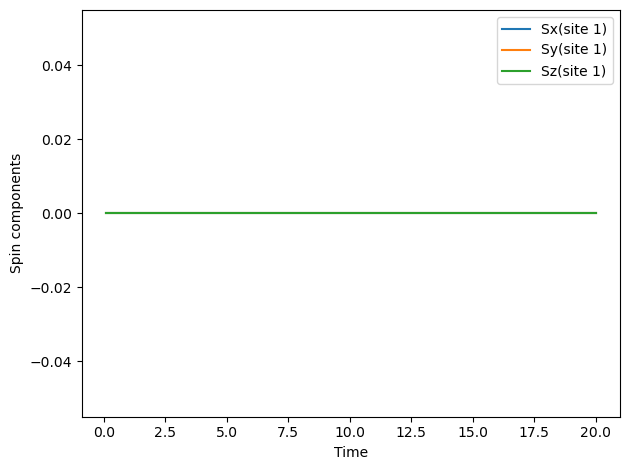

In [5]:
# Accumulate spin components over time and plot them
spin_vs_time = [Float64[] for _ in 1:3]  # 3 arrays: Sx, Sy, Sz

for t in 1:length(times)
    rho = density_matrix_from_gk(hist.gk, t)
    spin = spin_density(rho)
    push!(spin_vs_time[1], real(spin[1,1]))   # Sx (site 1)
    push!(spin_vs_time[2], real(spin[2,1]))   # Sy (site 1)
    push!(spin_vs_time[3], real(spin[3,1]))   # Sz (site 1)
end

Sx = spin_vs_time[1]
Sy = spin_vs_time[2]
Sz = spin_vs_time[3]


using PyPlot

fig, ax = subplots()
ax.plot(times, Sx, label="Sx(site 1)")
ax.plot(times, Sy, label="Sy(site 1)")
ax.plot(times, Sz, label="Sz(site 1)")
ax.set_xlabel("Time")
ax.set_ylabel("Spin components")
ax.legend()
fig.tight_layout()
show()

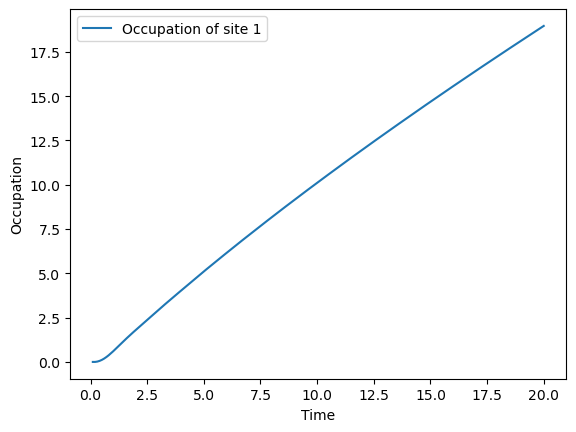

PyObject <matplotlib.legend.Legend object at 0x7f21770fdc10>

In [6]:
# Suppose times is your array of time points, and hist.gk is your Green's function history
occ_vs_time = []
#times = 1:length(hist.gk.ev)
for t in 1:length(times)
    rho = density_matrix_from_gk(hist.gk, t)
    occ = onsite_occupations(rho)
    push!(occ_vs_time, real(occ[1]))  # or occ[1] if you want the complex value
end

# Now plot
plot(times, occ_vs_time, label="Occupation of site 1")
xlabel("Time")
ylabel("Occupation")
legend()

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


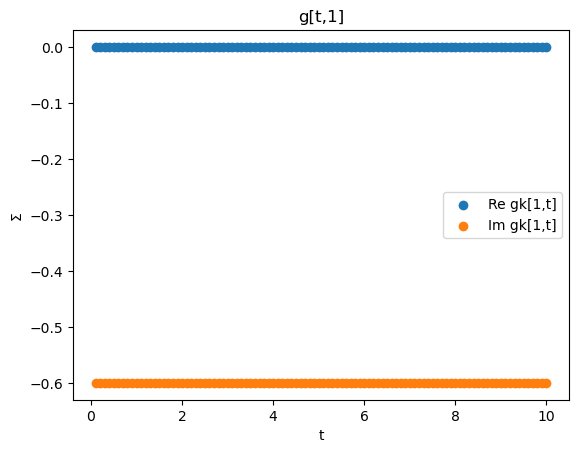

In [ ]:
vals_gk = [hist.gk[t,t][1,1,1,1] for t in 1:length(times)]
vals_gs = [hist.gs[t,t][1,1,1,1] for t in 1:length(times)]

# --- Plot
figure()

scatter(times, real.(vals_gk), label="Re gk[1,t]")
#scatter(times, real.(vals_gs), label="Re gs[1,t]", marker="x")
scatter(times, imag.(vals_gk), label="Im gk[1,t]")
#scatter(times, imag.(vals_gs), label="Im gs[1,t]", marker="x")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("g[t,1]")
legend()
#grid(true)
show()

In [ ]:
# Print all values of hist.gk[n1,n2,s1,s2] for a given t1, t2 to a file
function save_gk_elements(hist, t1, t2)
    G = hist.gk[t1, t2]
    dims = size(G)
    #open(filename, "w") do io
        for n1 in 1:dims[1], n2 in 1:dims[2], s1 in 1:dims[3], s2 in 1:dims[4]
            println("gk[", n1, ",", n2, ",", s1, ",", s2, "] = ", G[n1, n2, s1, s2])
        end
end

function save_Σk_elements(hist, t1, t2)
    G = hist.Σk[t1, t2]
    dims = size(G)
    for n1 in 1:dims[1], n2 in 1:dims[2], s1 in 1:dims[3]
        println("Σk[", n1, ",", n2, ",", s1, ",] = ", G[n1, n2, s1])
    end
end

save_Σk_elements (generic function with 1 method)

In [ ]:
save_gk_elements(hist, 2, 1 )

gk[1,1,1,1] = 1.732479314045e-312 - 0.99875im
gk[1,1,1,2] = 0.05 - 1.732479314065e-312im
gk[1,1,2,1] = 0.05 - 1.73247931405e-312im
gk[1,1,2,2] = 1.73247931407e-312 - 0.99875im
gk[1,2,1,1] = 1.73247931405e-312 - 1.73247931405e-312im
gk[1,2,1,2] = 1.73247931407e-312 - 1.73247931407e-312im
gk[1,2,2,1] = 1.73247931406e-312 - 1.73247931406e-312im
gk[1,2,2,2] = 1.732479314075e-312 - 1.73247931407e-312im
gk[2,1,1,1] = 1.732479314045e-312 - 1.732479314045e-312im
gk[2,1,1,2] = 1.732479314065e-312 - 1.732479314065e-312im
gk[2,1,2,1] = 1.732479314055e-312 - 1.732479314055e-312im
gk[2,1,2,2] = 1.73247931407e-312 - 1.73247931407e-312im
gk[2,2,1,1] = 1.73247931405e-312 - 0.99875im
gk[2,2,1,2] = 0.05 - 1.73247931407e-312im
gk[2,2,2,1] = 0.05 - 1.73247931406e-312im
gk[2,2,2,2] = 3.464930769586e-312 - 0.99875im


ComplexF64[0.0 - 4.5674040201531304e-17im, -0.08458579250975834 + 1.500984734181983e-17im, -0.16782120619845678 - 2.2241391129003418e-17im, -0.24838663020951804 - 2.7755575615628914e-17im, -0.3250231719493364 - 2.896988204881268e-16im, -0.3965609952690651 + 2.3592239273284576e-16im, -0.4619452993495203 - 2.5435382966509934e-16im, -0.5202592590444105 - 5.221958119822762e-19im, -0.5707433352536173 - 8.928389008550368e-18im, -0.612810468391776 - 6.244750403632329e-18im, -0.646056786195385 - 3.5171461663235926e-11im, -0.6702675846684883 - 4.973826428847361e-11im, -0.6854184768499039 - 6.232213009549348e-11im, -0.6916717375661566 - 7.242139526963953e-11im, -0.6893680094200607 - 7.963347863071402e-11im, -0.6790136617710175 - 8.367080726184861e-11im, -0.6612642134252662 - 8.437246474396476e-11im, -0.6369043347673772 - 8.171042488458458e-11im, -0.6068250338781617 - 1.1502707423713399e-17im, -0.5719987008971834 + 8.561809030846468e-18im, -0.5334527348359204 + 3.5945113666157116e-17im, -0.492242

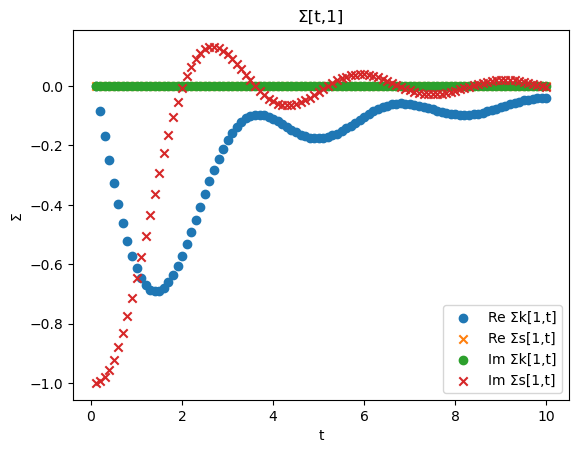

In [ ]:
vals_Σk = [hist.Σk[t,1][1,1,1] for t in 1:length(times)]
vals_Σs = [hist.Σs[t,1][1,1,1] for t in 1:length(times)]

println(vals_Σk)
# --- Plot
figure()

scatter(times, real.(vals_Σk), label="Re Σk[1,t]")
scatter(times, real.(vals_Σs), label="Re Σs[1,t]", marker="x")
scatter(times, imag.(vals_Σk), label="Im Σk[1,t]")
scatter(times, imag.(vals_Σs), label="Im Σs[1,t]", marker="x")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("Σ[t,1]")
legend()
#grid(true)
show()

ComplexF64[0.0 - 4.5674040201531304e-17im, 0.08458579250975834 + 1.500984734181983e-17im, 0.16782120619845678 - 2.2241391129003418e-17im, 0.24838663020951804 - 2.7755575615628914e-17im, 0.3250231719493364 - 2.896988204881268e-16im, 0.3965609952690651 + 2.3592239273284576e-16im, 0.4619452993495203 - 2.5435382966509934e-16im, 0.5202592590444105 - 5.221958119822762e-19im, 0.5707433352536173 - 8.928389008550368e-18im, 0.612810468391776 - 6.244750403632329e-18im, 0.646056786195385 - 3.5171461663235926e-11im, 0.6702675846684883 - 4.973826428847361e-11im, 0.6854184768499039 - 6.232213009549348e-11im, 0.6916717375661566 - 7.242139526963953e-11im, 0.6893680094200607 - 7.963347863071402e-11im, 0.6790136617710175 - 8.367080726184861e-11im, 0.6612642134252662 - 8.437246474396476e-11im, 0.6369043347673772 - 8.171042488458458e-11im, 0.6068250338781617 - 1.1502707423713399e-17im, 0.5719987008971834 + 8.561809030846468e-18im, 0.5334527348359204 + 3.5945113666157116e-17im, 0.49224250326693464 - 1.25140

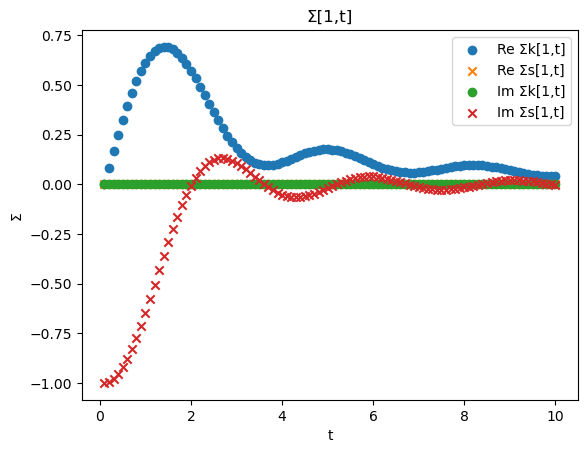

In [ ]:
vals_Σk = [hist.Σk[1,t][1,1,1] for t in 1:length(times)]
vals_Σs = [hist.Σs[1,t][1,1,1] for t in 1:length(times)]

println(vals_Σk)
# --- Plot
figure()

scatter(times, real.(vals_Σk), label="Re Σk[1,t]")
scatter(times, real.(vals_Σs), label="Re Σs[1,t]", marker="x")
scatter(times, imag.(vals_Σk), label="Im Σk[1,t]")
scatter(times, imag.(vals_Σs), label="Im Σs[1,t]", marker="x")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("Σ[1,t]")
legend()
#grid(true)
show()

ComplexF64[0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17im, 0.0 - 4.5674040201531304e-17i

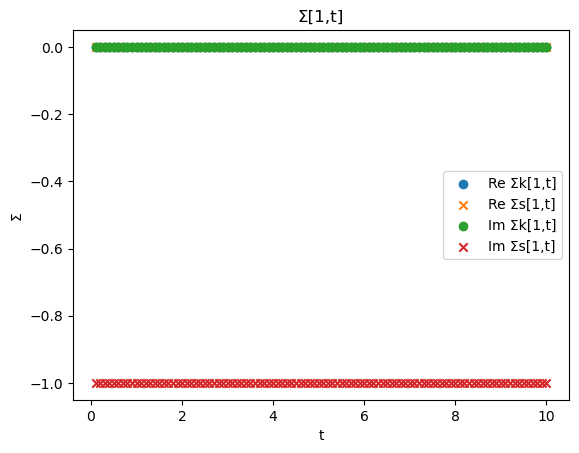

In [ ]:
vals_Σk = [hist.Σk[t,t][1,1,1] for t in 1:length(times)]
vals_Σs = [hist.Σs[t,t][1,1,1] for t in 1:length(times)]

println(vals_Σk)
# --- Plot
figure()

scatter(times, real.(vals_Σk), label="Re Σk[1,t]")
scatter(times, real.(vals_Σs), label="Re Σs[1,t]", marker="x")
scatter(times, imag.(vals_Σk), label="Im Σk[1,t]")
scatter(times, imag.(vals_Σs), label="Im Σs[1,t]", marker="x")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("Σ[1,t]")
legend()
#grid(true)
show()

In [ ]:
# Julia version
# gk is indexed as gk[t1, t2] -> 4D array G[n, sigma, n', sigma']
# t is the time-index for the equal-time value you want.

function density_matrix_from_gk(gk, t_index)
    G = gk[t_index, t_index]                # 4D array: (n, sigma, n', sigma')
    dims = size(G)                          # (Nn, Nsigma, Nn', Nsigma')
    @assert length(dims) == 4
    Nn, Nn2, Ns, Ns2 = dims
    @assert Nn == Nn2 && Ns == Ns2         # usually same dims for primed indices

    rho = zeros(ComplexF64, Nn, Nn, Ns, Ns)   # rho[n,σ,n',σ']
    for n in 1:Nn, n2 in 1:Nn, s in 1:Ns, s2 in 1:Ns
        delta = (n == n2 && s == s2) ? 1.0 : 0.0
        rho[s, s2,n,n2,] = 0.5*(delta - 1im * G[s,s2,n,n2])
    end
    return rho
end

# Get on-site occupation (sum over spin) N_n(t) = sum_sigma rho[n,σ,n,σ]
function onsite_occupations(rho)
    Nn, Ns, _, _ = size(rho)
    occ = zeros(ComplexF64, Nn)
    for n in 1:Nn
        for s in 1:Ns
            occ[n] += rho[s,s,n,n]   # take real part (small imag error may exist)
        end
    end
    return occ
end


onsite_occupations (generic function with 1 method)

In [ ]:
rho = density_matrix_from_gk(hist.gk,90)
occ = onsite_occupations(rho)
println("On-site occupations: ", occ)

On-site occupations: ComplexF64[NaN + NaN*im, NaN + NaN*im]


In [ ]:
rho

2×2 Matrix{ComplexF64}:
 0.75-0.00295432im  0.75-0.00295432im
 0.75+0.00295432im  0.75+0.00295432im

# Test

In [ ]:
function Γ(ϵ; γ=1.0, γc=1.0)
    if abs(ϵ) <= 2γ
        return (γc^2/γ^2) * sqrt(4γ^2 - ϵ^2)
    else
        return 0.0
    end
end
function compute_Σ0(γ, γc, βL, βR, μL, μR, t1, t2, n)  
    a, b = -2γ, 2γ
    Σs_0 = zeros(ComplexF64, 2, 2, n)
    Σk_0 = zeros(ComplexF64, 2, 2, n)

    Δt = t1 - t2
    # Σk (Left lead)
    fX(ϵ) = -im * Γ(ϵ;γ,γc) * exp(-im * ϵ * Δt) * (1 / (2π))

    Integral, _ = quadgk(fX, a, b; rtol=1e-8, atol=1e-10)
    Σs_0[1,1,1] = Integral
    Σs_0[2,2,1] = Integral

    # Σk (Right lead)
    #fX(ϵ) =  -im * (γc^2/(2γ^2)) * (ϵ -im * sqrt(4γ^2 - ϵ^2)) * exp(-im * ϵ * Δt) * (1 / (2π))

    #Integral, _ = quadgk(fX, a, b; rtol=1e-8, atol=1e-10)
    Σs_0[1,1,2] = Integral
    Σs_0[2,2,2] = Integral

    # Σs (Left lead)
    fX3(ϵ) = 0.5* im * Γ(ϵ;γ,γc) * (-1 + 2/(1 + exp(βL * (ϵ - μL)))) * exp(-im * ϵ * Δt) / (2π)

    IntegralSL, _ = quadgk(fX3, a, b; rtol=1e-8, atol=1e-10)
    Σk_0[1, 1, 1] = IntegralSL
    Σk_0[2, 2, 1] = IntegralSL

    # Σs (Right lead)

    fX4(ϵ) = 0.5* im  * Γ(ϵ;γ,γc) * (-1 + 2/(1 + exp(βR * (ϵ - μR)))) * exp(-im * ϵ * Δt) / (2π)

    IntegralSR, _ = quadgk(fX4, a, b; rtol=1e-8, atol=1e-10)
    Σk_0[1, 1, 2] = IntegralSR
    Σk_0[2, 2, 2] = IntegralSR

    return Σk_0, Σs_0
end

compute_Σ0 (generic function with 1 method)

In [ ]:
# parameters
Nt = 50
n = 2
γ, γc, βL, βR, μL, μR = 1.0, 1.0, 1/0.026, 1/0.026, 0., 0.
dt = 0.1

# storage
Σs = [zeros(ComplexF64, 2, 2, 2) for _ in 1:dt:Nt, _ in 1:dt:Nt]
Σk = [zeros(ComplexF64, 2, 2, 2) for _ in 1:dt:Nt, _ in 1:dt:Nt]


t1i = 1
t2i = 1

# loop for lower triangle
for t1 in 1:dt:Nt
    t2i = 1
    for t2 in 1:dt:t1
        Σk[t1i, t2i], Σs[t1i, t2i] = compute_Σ0(γ, γc, βL, βR, μL, μR, t1, t2, n)
        t2i += 1
    end
    t1i += 1
end



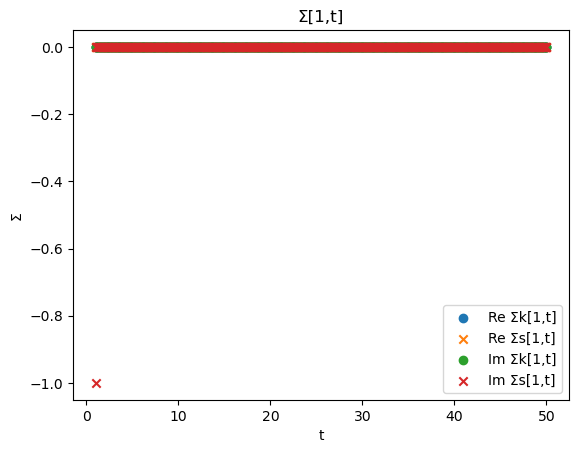

In [ ]:
N_size = size(Σs, 1)
index_t = 1:N_size   # or replace with your real time grid
times = 1:dt:Nt
idx = (1,1,1)  # orbital, orbital, lead indices to plot

# --- Extract values
vals_Σk = [Σk[1,t][idx...] for t in index_t]
vals_Σs = [Σs[1,t][idx...] for t in index_t]

# --- Plot
figure()

scatter(times, real.(vals_Σk), label="Re Σk[1,t]")
scatter(times, real.(vals_Σs), label="Re Σs[1,t]", marker="x")
scatter(times, imag.(vals_Σk), label="Im Σk[1,t]")
scatter(times, imag.(vals_Σs), label="Im Σs[1,t]", marker="x")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("Σ[1,t]")
legend()
#grid(true)
show()


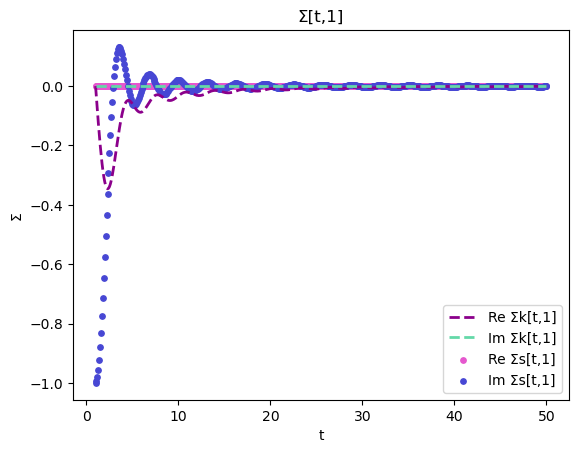

In [ ]:
vals_Σk .= [Σk[t,1][idx...] for t in index_t]
vals_Σs .= [Σs[t,1][idx...] for t in index_t]

# --- Plot
figure()

plot(times, real.(vals_Σk), label="Re Σk[t,1]", linestyle="--", linewidth=2, color = "#8B008B")
plot(times, imag.(vals_Σk), label="Im Σk[t,1]", linestyle="--", linewidth=2, color = "#64d8a8")
scatter(times, real.(vals_Σs), label="Re Σs[t,1]", s=15, color = "#e557ce")
scatter(times, imag.(vals_Σs), label="Im Σs[t,1]", s=15, color = "#4747D4")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("Σ[t,1]")
legend()
#grid(true)
show()


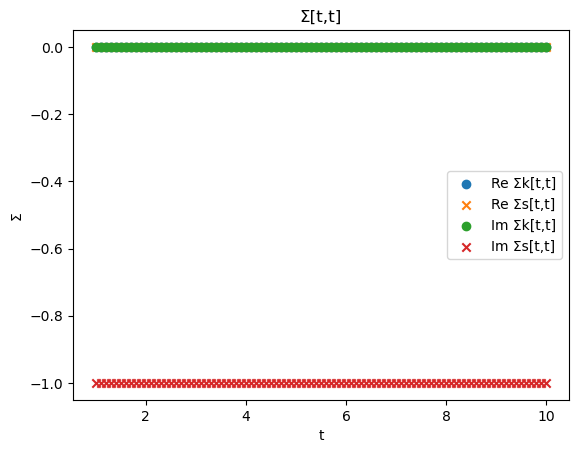

In [ ]:
vals_Σk = [Σk[t,t][idx...] for t in index_t]
vals_Σs = [Σs[t,t][idx...] for t in index_t]

figure()

scatter(times, real.(vals_Σk), label="Re Σk[t,t]")
scatter(times, real.(vals_Σs), label="Re Σs[t,t]", marker="x")
scatter(times, imag.(vals_Σk), label="Im Σk[t,t]")
scatter(times, imag.(vals_Σs), label="Im Σs[t,t]", marker="x")

xlabel("t")
ylabel("Σ")
# ylim(-1000, 2)   # uncomment if you want fixed y-limits
title("Σ[t,t]")
legend()
#grid(true)
show()
#println(imag.(vals_Σs))

In [ ]:
bath_params = BathParams(
    1,                  # N of baths
    [1],               # Sites with baths
    [1],                # Ohmic parameters
    [0.0, 0.0, 0],      # Bath couplings (separate different sites with spaces)
    [0.0],            # Temperatures
    [1],                 # Cutoff frequencies
);

times = 0.1:0.1:5
states = [[0,0,1]]
hist = create_history(times,states, 0.5, bath_params);

LoadError: MethodError: no method matching create_history(::Vector{Vector{Int64}}, ::Float64, ::BathParams, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64})

[0mClosest candidates are:
[0m  create_history(::Any, ::Any, ::Any, [91m::SpinParams[39m, [91m::BathParams[39m)
[0m[90m   @[39m [35mMain.Open2PIN[39m [90m/mnt/c/Users/nicol/OneDrive/Documents/ACADEMY/2025/FelipeKBE-02/Open2sPIN/[39m[90m[4mGreenTools.jl:114[24m[39m
[0m  create_history(::Any, ::Any, ::Any, [91m::SpinParams[39m)
[0m[90m   @[39m [35mMain.Open2PIN[39m [90m/mnt/c/Users/nicol/OneDrive/Documents/ACADEMY/2025/FelipeKBE-02/Open2sPIN/[39m[90m[4mGreenTools.jl:76[24m[39m


In [ ]:
@time evolve_pc_p!(hist, times, bath_params);

n=10
n=20
n=30
n=40
n=50
 34.608205 seconds (109.03 M allocations: 2.866 GiB, 1.46% gc time)


In [ ]:
@time evolve_pc!(hist, times, bath_params);

n=10
n=20
n=30
n=40
n=50
 33.476745 seconds (109.03 M allocations: 2.865 GiB, 1.45% gc time)


In [ ]:
res_pc = extract_components(hist);

In [ ]:
spins_sk = readdlm("../newData/spbs/c00t00wq00g02_sbs.txt");
spins_he = readdlm("../newData/heom/New/DT01W01C03Wq01.txt");

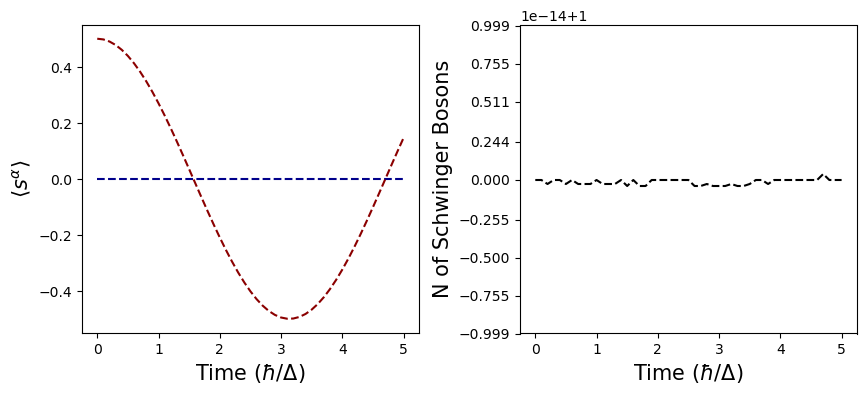

In [ ]:
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fs=15

# ax[1].plot(spins_sk[:,1], spins_sk[:,2], "b")
# ax[1].plot(spins_sk[:,1], spins_sk[:,4], "r")

# taux = 0.01:0.01:30
# ax[1].plot(taux[1:60:end], 0.5*spins_he[1:60:end,1], "bo", mfc="white")
# ax[1].plot(taux[1:60:end], 0.5*spins_he[1:60:end,2], "ro", mfc="white")

ax[1].plot(real(res_pc[:,1]), real(res_pc[:,2]), "--", color="darkblue")
ax[1].plot(real(res_pc[:,1]), real(res_pc[:,4]), "--", color="darkred")

# ax[2].plot(spins_sk[:,1], spins_sk[:,5], "k")
ax[2].plot(real(res_pc[:,1]), real(res_pc[:,5]), "k", ls="dashed")

# ax[1].set_ylim(-0.6,0.6)
ax[2].set_ylim(1-1e-14,1+1e-14)

for i in 1:2
    ax[i].set_xlabel(raw"Time $(\hbar/\Delta)$", fontsize=fs)
end
    
ax[1].set_ylabel(raw"$\langle s^\alpha \rangle$", fontsize=fs)
ax[2].set_ylabel(raw"N of Schwinger Bosons", fontsize=fs);

In [ ]:
# g_kel = [[make_spin_complex(hist.gf[i,j]) for j in 1:i] for i in 1:101];
# col_g_kel = [vec(g_kel[i][1]) for i in 1:101]
# col_g_kel = hcat(col_g_kel...)

# zcomp = res_pc[:,4];

# writedlm("zcomp.txt", zcomp)
# writedlm("colgkel.txt", col_g_kel)

zcomp = readdlm("zcomp.txt")
col_g_kel = readdlm("colgkel.txt", '\t', Complex{Float64});

In [ ]:
g_ret = [[make_spin_complex(hist.gρ[i,j])/2 for j in 1:i] for i in 1:101];

weights = [[3, 0] [0, 1]]
pauli_z = [[1, 0] [0,-1]]

rec_col_g_kel = [vec(-1im*g_ret[i][1]*weights*g_ret[1][1]') for i in 1:101]
rec_col_g_kel = hcat(rec_col_g_kel...)

rec_dia_g_kel =  [-1im*g_ret[i][1]*weights*g_ret[i][1]' for i in 1:101]
rec_zcomp = [-0.25*tr(g*pauli_z) for g in rec_dia_g_kel];

In [ ]:
data = hcat(res_pc[:,1], real(zcomp), imag(rec_zcomp), real(col_g_kel[2,:]), real(rec_col_g_kel[2,:]));
writedlm("recons_data.txt", data)

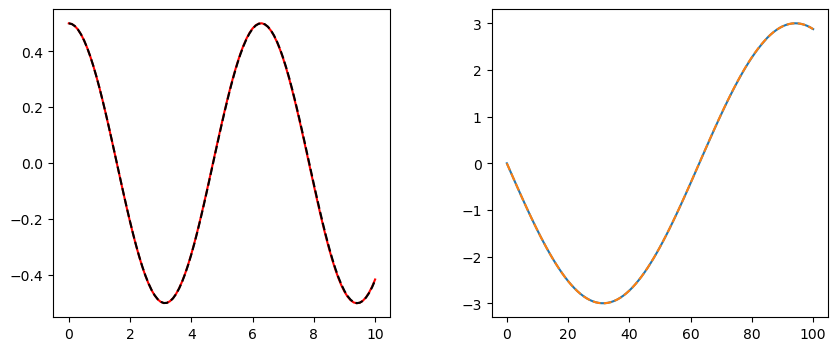

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000027D588E4F80>

In [ ]:
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fs=15

ax[1].plot(res_pc[:,1], zcomp, "r")
ax[1].plot(res_pc[:,1], imag(rec_zcomp), "k--")

ax[2].plot(real(col_g_kel[2,:]))
ax[2].plot(real(rec_col_g_kel[2,:]), "--")



In [ ]:
N = 4
spin_params = SpinParams(
    N,                           # Number of spins
    zeros(3,3,N,N),              # Heisenberg exchange J
    [0,0,0]                    # External field
)

J = diagm([1,1,1]) # Defining AF XXZ coupling with Z FM
@tullio spin_params.J[α,β,i,i+1] = 0.5*J[α,β]
@tullio spin_params.J[α,β,i,i-1] = 0.5*J[α,β];

spin_params.J[:,:,1,N]= 0.5J
spin_params.J[:,:,N,1]= 0.5J;

times = 0.1:0.1:6
states = [[0,0,1], [0,0,-1], [0,0,1], [0,0,-1]]
hist4 = create_history(states, 0.5, spin_params);

@time evolve_pc_p!(hist4, times, spin_params);

n=10
n=20
n=30
n=40
n=50
n=60
 66.092908 seconds (3.24 G allocations: 98.135 GiB, 23.55% gc time, 49.78% compilation time: <1% of which was recompilation)


In [ ]:
N = 6
spin_params = SpinParams(
    N,                           # Number of spins
    zeros(3,3,N,N),              # Heisenberg exchange J
    [0,0,0]                    # External field
)

J = diagm([1,1,1]) # Defining AF XXZ coupling with Z FM
@tullio spin_params.J[α,β,i,i+1] = 0.5*J[α,β]
@tullio spin_params.J[α,β,i,i-1] = 0.5*J[α,β];

spin_params.J[:,:,1,N]= 0.5J
spin_params.J[:,:,N,1]= 0.5J;

times = 0.1:0.1:6
states = [[0,0,1], [0,0,-1], [0,0,1], [0,0,-1], [0,0,1], [0,0,-1]]
hist6 = create_history(states, 0.5, spin_params);

@time evolve_pc_p!(hist6, times, spin_params);

n=10
n=20
n=30
n=40
n=50
n=60
112.798500 seconds (10.73 G allocations: 321.276 GiB, 37.69% gc time)


In [ ]:
N = 10
spin_params = SpinParams(
    N,                           # Number of spins
    zeros(3,3,N,N),              # Heisenberg exchange J
    [0,0,0]                    # External field
)

J = diagm([1,1,1]) # Defining AF XXZ coupling with Z FM
@tullio spin_params.J[α,β,i,i+1] = 0.5*J[α,β]
@tullio spin_params.J[α,β,i,i-1] = 0.5*J[α,β];

spin_params.J[:,:,1,N]= 0.5J
spin_params.J[:,:,N,1]= 0.5J;

times = 0.1:0.1:6
states = [[0,0,1], [0,0,-1], [0,0,1], [0,0,-1], [0,0,1], [0,0,-1], [0,0,1], [0,0,-1], [0,0,1], [0,0,-1]]
hist10 = create_history(states, 0.5, spin_params);

@time evolve_pc_p!(hist10, times, spin_params);

n=10
n=20
n=30
n=40
n=50
n=60
466.397388 seconds (49.54 G allocations: 1.446 TiB, 40.98% gc time)


In [ ]:
res4 = extract_components(hist4);
res6 = extract_components(hist6);
# res10 = extract_components(hist10);

In [ ]:
stg_mag4 = zeros(length(res4[:,1]))
N=4
for i=1:N
    sgn = (-1)^i
    stg_mag4 += res4[:,1+2N+i]*sgn
end

stg_mag6 = zeros(length(res6[:,1]))
N=6
for i=1:N
    sgn = (-1)^i
    stg_mag6 += res6[:,1+2N+i]*sgn
end

# stg_mag10 = zeros(length(res10[:,1]))
# N=10
# for i=1:N
#     sgn = (-1)^i
#     stg_mag10 += res10[:,1+2N+i]*sgn
# end

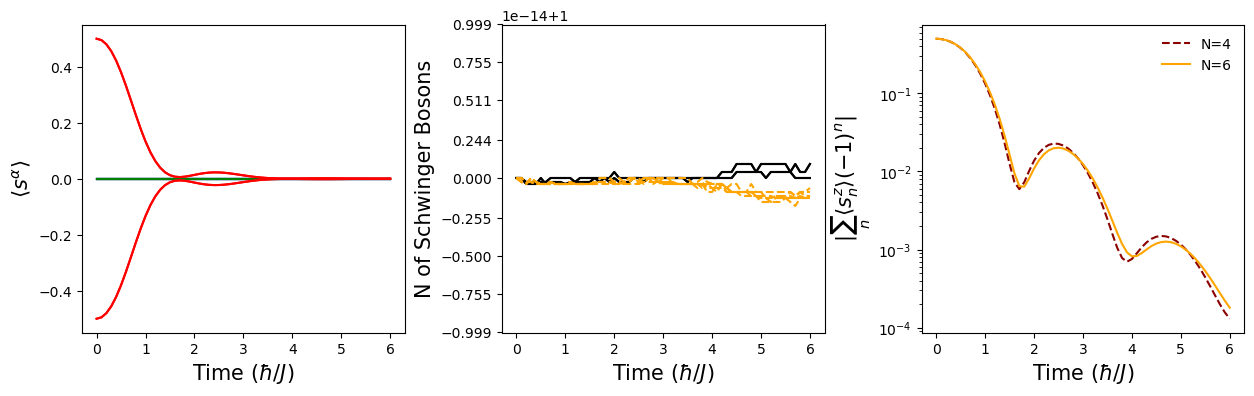

PyObject <matplotlib.legend.Legend object at 0x7f30dfd2dbb0>

In [ ]:
fig, ax= plt.subplots(nrows = 1, ncols = 3, figsize=(15,4))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fs=15

N=4
ax[1].plot(real(res4[:,1]), real(res4[:,2:1+N]), color="b")
ax[1].plot(real(res4[:,1]), real(res4[:,2+N:1+2N]), color="g")
ax[1].plot(real(res4[:,1]), real(res4[:,2+2N:1+3N]), color="r")

ax[2].plot(real(res4[:,1]), real(res4[:,2+3N:end]), "k")
N=6
ax[2].plot(real(res6[:,1]), real(res6[:,2+3N:end]), "orange", ls="dashed")
# N=10
# ax[2].plot(real(res10[:,1]), real(res10[:,2+3N:end]), "purple", ls="dotted")

ax[3].plot(real(res4[:,1]), abs.(stg_mag4)/4, "darkred", ls="dashed", label = "N=4")
ax[3].plot(real(res6[:,1]), abs.(stg_mag6)/6, "orange", label = "N=6")
# ax[3].plot(real(res10[:,1]), abs.(stg_mag10)/10, ls="dashed", label = "N=10")

# ax[1].set_ylim(-0.6,0.6)
ax[2].set_ylim(1-1e-14,1+1e-14)
ax[3].set_yscale("log")

for i in 1:3
    ax[i].set_xlabel(raw"Time $(\hbar/J)$", fontsize=fs)
end
    
ax[1].set_ylabel(raw"$\langle s^\alpha \rangle$", fontsize=fs)
ax[2].set_ylabel(raw"N of Schwinger Bosons", fontsize=fs);
ax[3].set_ylabel(raw"$|\sum_n \langle s^z_n\rangle (-1)^n|$", fontsize=fs);

ax[3].legend(frameon = false)

In [ ]:
N = 4
spin_params = SpinParams(
    N,                           # Number of spins
    zeros(3,3,N,N),              # Heisenberg exchange J
    [0.5,0,0]                    # External field
)

J = [[1, -0.05, 0] [-0.05, 1, -0.05] [0, -0.05, 1]] # Defining AF XXZ coupling with Z FM
@tullio spin_params.J[α,β,i,i+1] = 0.5*J[α,β]
@tullio spin_params.J[α,β,i,i-1] = 0.5*J[α,β];

# spin_params.J[:,:,1,N]= 0.5J
# spin_params.J[:,:,N,1]= 0.5J;

bath_params = BathParams(
    2,                                  # N of baths
    [1,N],                              # Sites with baths
    [1,1],                              # Ohmic parameters
    [[0.1,0.1,0.1] [0.1,0.1,0.1]],      # Bath couplings (separate different sites with spaces)
    [5.0, 0.0],                         # Temperatures
    [3,3],                              # Cutoff frequencies
);

times = 0.1:0.1:10
states = [[0,0,1], [0,0,-1], [0,0,1], [0,0,-1]]
hist = create_history(states, 0.5, spin_params, bath_params, times);

In [ ]:
@time evolve_pc_p!(hist, times, spin_params, bath_params);

n=10
n=20
n=30
n=40
n=50
n=60
n=70
n=80
n=90
n=100
248.769462 seconds (16.28 G allocations: 487.795 GiB, 29.45% gc time)


In [ ]:
res = extract_components(hist);

In [ ]:
cxx = [-hist.mf[i,i][1,1,2,3]/4 for i=1:length(hist.times)];
cyy = [-hist.mf[i,i][2,2,2,3]/4 for i=1:length(hist.times)];
czz = [-hist.mf[i,i][3,3,2,3]/4 for i=1:length(hist.times)];

jz = cxx .+ cyy;
jx = cyy .+ czz
jy = cxx .+ czz;

In [ ]:
cxy = [-hist.mf[i,i][1,2,2,3]/4 for i=1:length(hist.times)];
cyx = [-hist.mf[i,i][2,1,2,3]/4 for i=1:length(hist.times)];

czy = [-hist.mf[i,i][3,2,2,3]/4 for i=1:length(hist.times)];
cyz = [-hist.mf[i,i][2,3,2,3]/4 for i=1:length(hist.times)];

jz = cxy .- cyx;
jx = czy .- cyz;

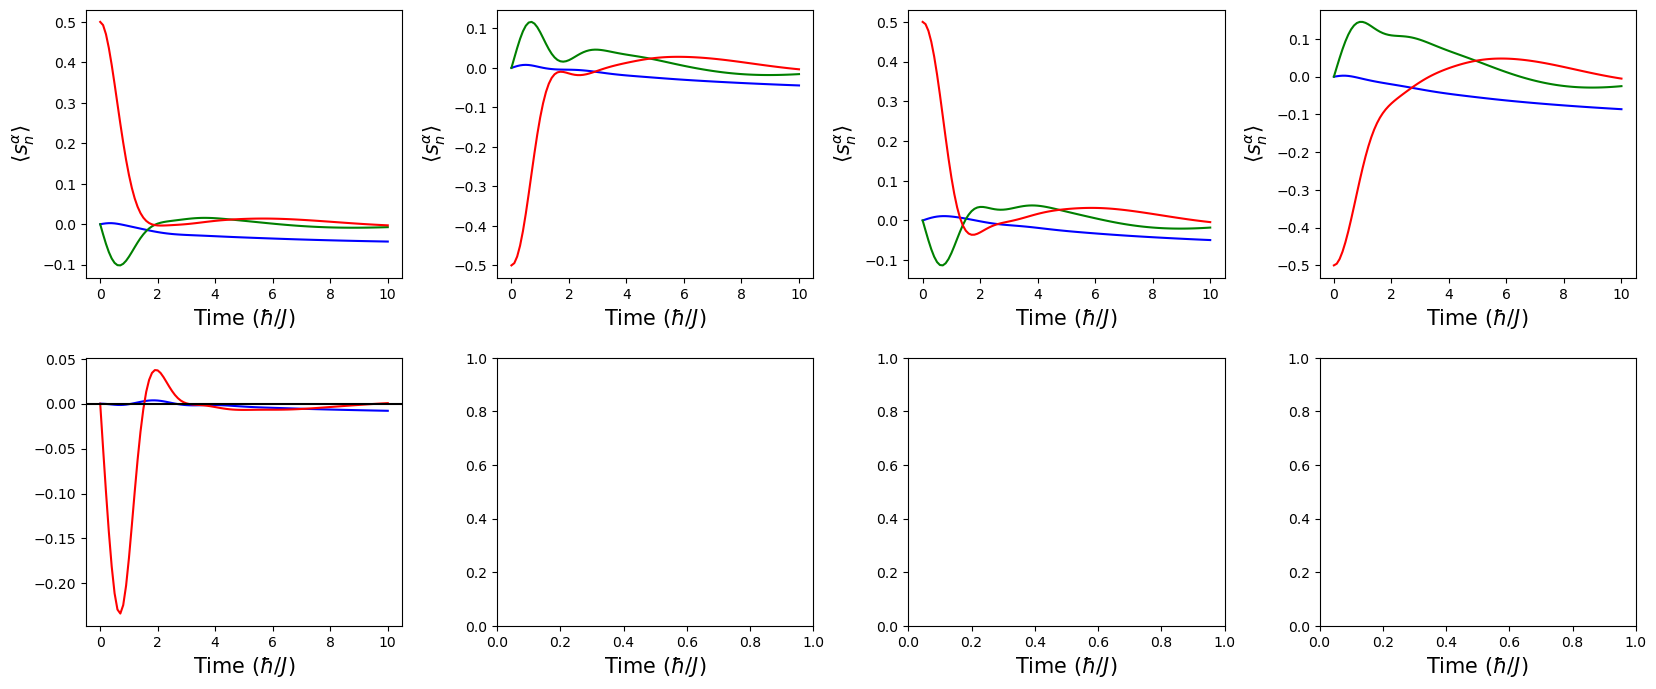

In [ ]:
fig, ax= plt.subplots(nrows = 2, ncols = 4, figsize=(20,8))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fs=15

for i = 1:4
    ax[2*i-1].plot(res[:,1], res[:,1+i], color="b")
    ax[2*i-1].plot(res[:,1], res[:,5+i], color="g")
    ax[2*i-1].plot(res[:,1], res[:,9+i], color="r")
    
#     ax[2*i-1].plot(res[:,1], res1[:,1+i], "k--")
#     ax[2*i-1].plot(res[:,1], res1[:,5+i], "k--")
#     ax[2*i-1].plot(res[:,1], res1[:,9+i], "k--")
    
    ax[2*i-1].set_ylabel(raw"$\langle s^\alpha_n \rangle$", fontsize=fs)
end

ax[2].plot(res[:,1], imag(jx), color="b")
# ax[2].plot(res[:,1], imag(jy), color="g")
ax[2].plot(res[:,1], imag(jz), color="r")

# ax[2].set_ylim(-0.01,0)
# ax[5].set_ylim(1-1e-14,1+1e-14)

ax[2].axhline(y=0, color="k")

for i in 1:8
    ax[i].set_xlabel(raw"Time $(\hbar/J)$", fontsize=fs)
end
    
# ax[5].set_ylabel(raw"N of Schwinger Bosons", fontsize=fs);

In [ ]:
bath_params = BathParams(
    1,                  # N of baths
    [1],               # Sites with baths
    [1],                # Ohmic parameters
    [0.0,0.0,20],      # Bath couplings (separate different sites with spaces)
    [0.0],            # Temperatures
    [1],                 # Cutoff frequencies
    [1,0,0]         # External field
);

times = 0.02:0.02:5
states = [[0,0,1]]
hist = create_history(states, 0.5, bath_params, times);

In [ ]:
@time evolve_pc_p!(hist, times, bath_params);

n=10
n=20
n=30
n=40
n=50
n=60
n=70
n=80
n=90
n=100
n=110
n=120
n=130
n=140
n=150
n=160
n=170
n=180
n=190
n=200
n=210
n=220
n=230
n=240
n=250
2976.857283 seconds (56.00 G allocations: 1.434 TiB, 9.38% gc time)


In [ ]:
res = extract_components(hist);

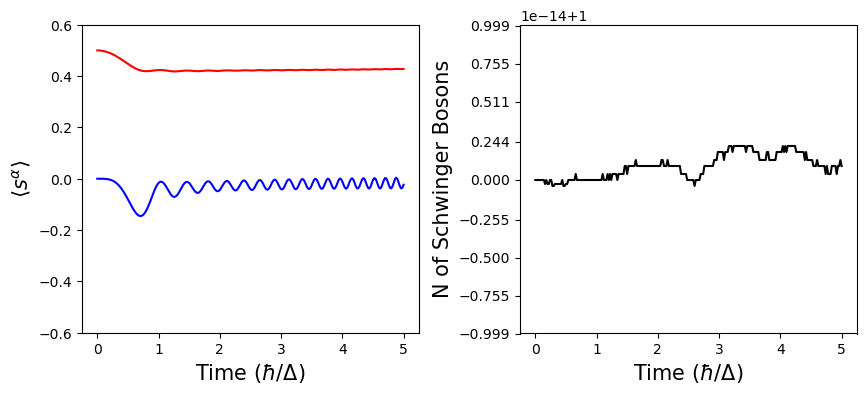

In [ ]:
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fs=15

ax[1].plot(res[:,1], res[:,2], color="blue")
ax[1].plot(res[:,1], res[:,4], color="red")

ax[2].plot(res[:,1], res[:,5], "k")

ax[1].set_ylim(-0.6,0.6)
ax[2].set_ylim(1-1e-14,1+1e-14)

for i in 1:2
    ax[i].set_xlabel(raw"Time $(\hbar/\Delta)$", fontsize=fs)
end
    
ax[1].set_ylabel(raw"$\langle s^\alpha \rangle$", fontsize=fs)
ax[2].set_ylabel(raw"N of Schwinger Bosons", fontsize=fs);

In [ ]:
N = 2
spin_params = SpinParams(
    N,                           # Number of spins
    zeros(3,3,N,N),              # Heisenberg exchange J
    [1,0,0]                    # External field
)

J = -0.05*diagm([1,1,1]) # Defining AF XXZ coupling with Z FM
@tullio spin_params.J[α,β,i,i+1] = 0.5*J[α,β]
@tullio spin_params.J[α,β,i,i-1] = 0.5*J[α,β];

bath_params = BathParams(
    2,                         # N of baths
    [1,2],                     # Sites with baths
    [1,1],                     # Ohmic parameters
    [[0.0,0.0,2] [0,0,2]], # Bath couplings (separate different sites with spaces)
    [0.0, 0.0],                # Temperatures
    [1,1],                 # Cutoff frequencies
);

times = 0.15:0.15:10
states = [[0,0,1], [0,0,1]]
hist = create_history(states, 0.5, spin_params, bath_params, times);

@time evolve_pc_p!(hist, times, spin_params, bath_params);

n=10
n=20
n=30
n=40
n=50
n=60
 27.401757 seconds (929.36 M allocations: 27.798 GiB, 14.97% gc time)


In [ ]:
bath_params = BathParams(
    1,                  # N of baths
    [1],               # Sites with baths
    [1],                # Ohmic parameters
    [0.0,0.0,1],      # Bath couplings (separate different sites with spaces)
    [0.0],            # Temperatures
    [1],                 # Cutoff frequencies
    [1,0,0]         # External field
);

times = 0.2:0.2:20
states = [[0,0,1]]
hist1 = create_history(states, 0.5, bath_params, times);

@time evolve_pc_p!(hist1, times, bath_params);

n=10
n=20
n=30
n=40
n=50
n=60
n=70
n=80
n=90
n=100
 84.691054 seconds (1.54 G allocations: 40.276 GiB, 7.81% gc time)


In [ ]:
res = extract_components(hist);
res1 = extract_components(hist1);

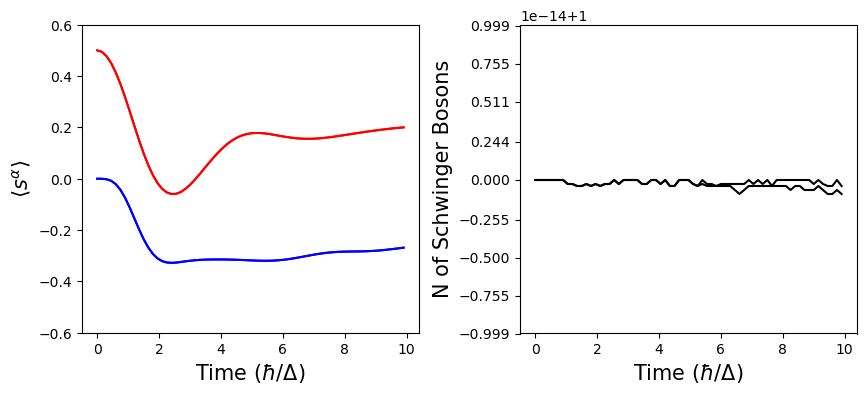

In [ ]:
fig, ax= plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

fig.subplots_adjust(wspace=0.3, hspace=0.3)
fs=15

ax[1].plot(res[:,1], res[:,2:3], color="blue")
ax[1].plot(res[:,1], res[:,6:7], color="red")

# ax[1].plot(res1[:,1], res1[:,2], color="darkblue", ls="--")
# ax[1].plot(res1[:,1], res1[:,4], color="darkred", ls="--")

ax[2].plot(res[:,1], res[:,8:9], "k")
# ax[2].plot(res1[:,1], res1[:,5], "orange", ls = "--")


ax[1].set_ylim(-0.6,0.6)
ax[2].set_ylim(1-1e-14,1+1e-14)

for i in 1:2
    ax[i].set_xlabel(raw"Time $(\hbar/\Delta)$", fontsize=fs)
end
    
ax[1].set_ylabel(raw"$\langle s^\alpha \rangle$", fontsize=fs)
ax[2].set_ylabel(raw"N of Schwinger Bosons", fontsize=fs);

In [ ]:
cssρ = [-hist.mρ[i,1][3,3,1,2]/4 for i=1:length(hist.times)];
cssf = [-hist.mf[i,1][3,3,1,2]/4 for i=1:length(hist.times)];

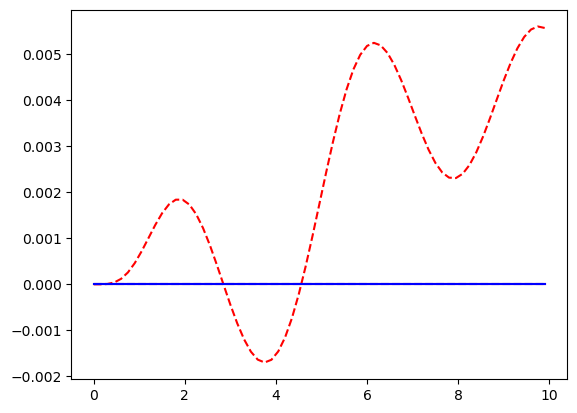

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7efeeb789af0>

In [ ]:
plt.plot(hist.times, real(cssf), "r")
plt.plot(hist.times, imag(cssf), "r--")
plt.plot(hist.times, real(cssρ), "b")
plt.plot(hist.times, imag(cssρ), "b--")

In [ ]:
spin_sk = readdlm("../newData/skft_jl/wc3.0_T0.0_g0.50_wq0.0_s1.0_skft.txt");

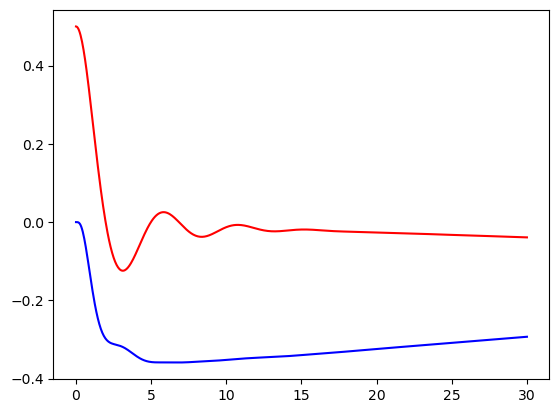

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f3100a75370>

In [ ]:
plt.plot(spin_sk[:,1], spin_sk[:,2], "b")
plt.plot(spin_sk[:,1], spin_sk[:,4], "r")